In [10]:
import numpy as np
import matplotlib.pyplot as plt
import deepxde.deepxde as dde
import deepxde.deepxde.backend as bkd
from datasets import makeTesting
from datasets import parallel_solver, diffusion_reaction_solver
import time
from scipy import interpolate

In [11]:
if False:
    makeTesting()

In [12]:
def pde(x, y):
    vx = x[0].repeat_interleave(101)[:,None]

    D = 0.01
    k = 0.01
    dy_t = dde.grad.jacobian(y, x[1], j=1)
    dy_xx = dde.grad.hessian(y, x[1], j=0)
    return dy_t - D * dy_xx + k * y**2 - vx

In [13]:
space = dde.data.GRF(1.0, length_scale = 0.1, N= 1000, interp="cubic")
vxs = space.eval_batch(space.random(20), np.linspace(0, 1, 101)[:, None])
uxts = parallel_solver(diffusion_reaction_solver, vxs, num_workers = 6)
grid = uxts[0][0].reshape(101 * 101, -1)
uxts = np.asarray([u for grid, u in uxts]).reshape(-1, 101 * 101)


train_vxs = vxs
train_grid = grid
train_uxts = uxts
print(train_vxs.shape, train_grid.shape, train_uxts.shape)

test_data = np.load("datasets/DF_100_0.1_101_101.npz")
test_vxs = test_data["vxs"]
test_grid = test_data["xt"].reshape(-1, 2)
test_uxts = test_data["uxts"].reshape(-1, 101 * 101)
del test_data
print(test_vxs.shape, test_grid.shape, test_uxts.shape)

(20, 101) (10201, 2) (20, 10201)
(100, 101) (10201, 2) (100, 10201)


Compiling model...
'compile' took 0.000612 s

Training model...

0         [2.67e-01]    [2.25e-01]    [1.07e+00]    


1000      [2.34e-02]    [4.66e-02]    [4.86e-01]    
2000      [9.22e-03]    [4.94e-02]    [5.01e-01]    
3000      [5.31e-03]    [6.80e-02]    [5.87e-01]    
4000      [3.85e-03]    [7.77e-02]    [6.28e-01]    
5000      [3.14e-03]    [7.28e-02]    [6.07e-01]    

Best model at step 5000:
  train loss: 3.14e-03
  test loss: 7.28e-02
  test metric: [6.07e-01]

'train' took 68.782721 s

Error in callback <function _draw_all_if_interactive at 0x7fa6e97cf490> (for post_execute):


KeyboardInterrupt: 

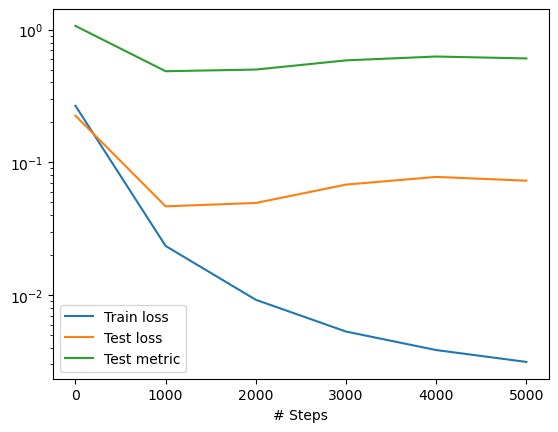

In [14]:
data = dde.data.TripleCartesianProd(X_train=(train_vxs, train_grid), y_train=train_uxts, X_test=(test_vxs, test_grid), y_test=test_uxts)

# Net
net = dde.nn.DeepONetCartesianProd(
    [101, 128, 128, 128],
    [2, 128, 128, 128],
    bkd.gelu,
    "Glorot normal",
)

model = dde.Model(data, net)
model.compile("adam", lr=1E-3, metrics = ["l2 relative error"])
losshistory, train_state = model.train(iterations=5000)
dde.utils.plot_loss_history(losshistory)

In [15]:

while len(train_vxs) < 1000:
    # generate some vxs to test
    x_space = np.linspace(0, 1, 101)
    t_space = np.linspace(0, 1, 101)
    vxs = space.eval_batch(space.random(100), x_space[:, None])
    grid = np.asarray(np.meshgrid(x_space, t_space, indexing = "ij")).transpose([1,2,0]).reshape(101 * 101, -1)
    res = model.predict((vxs, grid), operator = pde)
    res = np.mean(np.abs(res[...,0]), axis = 1)
    print(min(res), max(res))
    topk_index = np.argpartition(res, -20)[-20:]
    topk_vxs = vxs[topk_index]
    uxts = parallel_solver(diffusion_reaction_solver, topk_vxs, num_workers = 6)
    uxts = np.asarray([u for grid, u in uxts]).reshape(-1, 101 * 101)

    # then add the new data to the training set, and train the model
    train_vxs = np.concatenate([train_vxs, topk_vxs], axis = 0)
    train_uxts = np.concatenate([train_uxts, uxts], axis = 0)
    
    print(len(train_vxs))
    data = dde.data.TripleCartesianProd(X_train=(train_vxs, train_grid), y_train=train_uxts, X_test=(test_vxs, test_grid), y_test=test_uxts)
    
    model = dde.Model(data, net)
    model.compile("adam", lr=1E-3, metrics = ["l2 relative error"])
    losshistory, train_state = model.train(iterations=len(train_vxs) * 10)
        


40
Compiling model...
'compile' took 0.000769 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.02e-01]    [7.28e-02]    [6.07e-01]    
400       [4.52e-03]    [3.52e-02]    [4.22e-01]    

Best model at step 400:
  train loss: 4.52e-03
  test loss: 3.52e-02
  test metric: [4.22e-01]

'train' took 5.005798 s

60
Compiling model...
'compile' took 0.000343 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.61e-02]    [3.52e-02]    [4.22e-01]    
600       [4.53e-03]    [2.14e-02]    [3.29e-01]    

Best model at step 600:
  train loss: 4.53e-03
  test loss: 2.14e-02
  test metric: [3.29e-01]

'train' took 8.391376 s

80
Compiling model...
'compile' took 0.000337 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.34e-02]    [2.14e-02]    [3.29e-01]    
800       [3.55e-03]    [1.70e-02]    [2.93e-01]    

Best model at step 800:
  train loss: 3.55e-03
  test loss: 1.70e-02
  tes

KeyboardInterrupt: 